# Forward model using the Waveform Simulator

*Bart Pelssers, 27-03-2018*

Provides forward model for the ABC project using the Pax Waveform Simulator (Fax).


In [1]:
import numpy as np

In [2]:
from abc_reconstruction.model import Model

In [3]:
# Initialize the model
model = Model('XENON1T_ABC.ini')  # or use 'XENON1T_ABC.ini' to have some top PMTs off

### this is because we will vectorize model (for using elfi.Distance) but we need to get the hitpattern as the event changes
model_only_y_obs = Model('XENON1T_ABC.ini')  # or use 'XENON1T_ABC.ini' to have some top PMTs off

You don't have ROOT or root_pandas, root truth file output is disabled


In [4]:
# OPTIONALLY: Set different defaults for z,t,recoil_type,s1_photons_s2_electrons: if, CHANGE ON BOTH
model.change_defaults(s2_electrons = 25)
model_only_y_obs.change_defaults(s2_electrons = 25)

In [5]:
# View the current defaults
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '50',
 's2_electrons': '25',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0.0'}

# Python 3.5 and ELFI

In [6]:
import sys
sys.version

'3.5.5 |Anaconda, Inc.| (default, Mar 12 2018, 23:12:44) \n[GCC 7.2.0]'

In [7]:
import elfi

In [8]:
###Observed dataset
trueCoordMatrix=np.loadtxt('data/truepos')
print("True Coordinates")

###pick an event j
j=0
print(trueCoordMatrix[j])

trueCoord=trueCoordMatrix[j]
TrueModel=model_only_y_obs(trueCoord[0], trueCoord[1])

y_obs=TrueModel
print(y_obs)

True Coordinates
[  2.62643434 -17.96082368]
[ 0.          0.          0.          0.          0.          0.
  0.          0.43250721  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.92764804
  0.79515099  2.33421234  2.4181994   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.57938262  1.07491368  0.          0.          1.1133384   0.
  1.00260921  0.          0.          1.32904873  0.          0.
  0.          0.          0.          3.83830639  4.96518321  1.20595952
  0.          1.1867409   0.          0.          0.          0.80256022
  1.37807274  0.          0.          0.          0.          0.
  4.81802093  0.          0.          0.          0.          0.95647437
  0.          0.          0.          1.80379368  5.34854047  6.32328635
 10.8826264   0.         10.96031275  1.78981145  2.60420971  0.
  1.4

In [9]:
pos_dict = model_only_y_obs.get_latest_pax_position()
pos_dict

{'PosRecNeuralNet': {'x': 2.349253472591718, 'y': -18.209215419818623},
 'PosRecTopPatternFit': {'x': 2.3690476190476133, 'y': -17.830200501253135}}

In [10]:
from abc_reconstruction.utils import PriorPosition

In [11]:
prior_mean = PriorPosition()
naiveCoord=prior_mean(y_obs)

print(naiveCoord)

(4.115222817130077, -15.358220637996187)


In [12]:
###Prior distributions: REMEMBER TO ADD THE CONSTRAINT

#xProp=elfi.Prior('norm',trueCoord[0],10)
#yProp=elfi.Prior('norm',trueCoord[1],10)
xProp=elfi.Prior('norm',naiveCoord[0],10)
yProp=elfi.Prior('norm',naiveCoord[1],10)

#print(elfi.Simulator.generate(xProp), elfi.Simulator.generate(yProp))

In [13]:
#we need to vectorize model, because of elfi.Distance. Do it only once
model=elfi.tools.vectorize(model)

In [14]:
###Simulated Dataset
Y = elfi.Simulator(model, xProp, yProp, observed=y_obs)
#Y = elfi.Simulator(model, xProp, yProp)
#print(elfi.Simulator.generate(Y))

In [15]:
elfi.Simulator.generate(Y)

array([[ 0.        ,  0.        ,  0.        ,  1.15557533,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.23615253,  0.        ,  0.        ,  5.21583727,  7.96958555,
        27.05871752, 61.48211495, 23.90004143,  3.71973065,  2.38114944,
         1.1626222 ,  2.44099102,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.59296933,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.66888024,  1.43326131,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.07216678,  1.23453644,  5.64636882, 15.74583526, 54.98983095,
        38.76075128,  4.22239152,  0.        ,  1.06971215,  1.44109054,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.6940985 ,
         0.        ,  0.        ,  0.        ,  1.7

In [16]:
d = elfi.Distance('euclidean', Y)

print(elfi.Simulator.generate(d))

[129.81533477]


In [17]:
log_d = elfi.Operation(np.log, d)

print(elfi.Simulator.generate(log_d))

[4.51414672]


In [18]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=50, update_interval=10, 
                   bounds={'xProp':(-30, 30), 'yProp':(-30, 30)}, acq_noise_var=[0.1, 0.1])

In [19]:
%time post = bolfi.fit(n_evidence=200)

CPU times: user 6min 19s, sys: 9min 10s, total: 15min 30s
Wall time: 2min 34s


In [20]:
bolfi.target_model


Name : GP regression
Objective : -27.882142427336284
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors   
  sum.rbf.variance         |   0.06080964263434358  |      +ve      |  Ga(1.8, 1) 
  sum.rbf.lengthscale      |     5.133227948539352  |      +ve      |   Ga(20, 1) 
  sum.bias.variance        |    3.1621756369646086  |      +ve      |  Ga(0.46, 1)
  Gaussian_noise.variance  |  0.019967821063199418  |      +ve      |             

<Figure size 432x288 with 0 Axes>

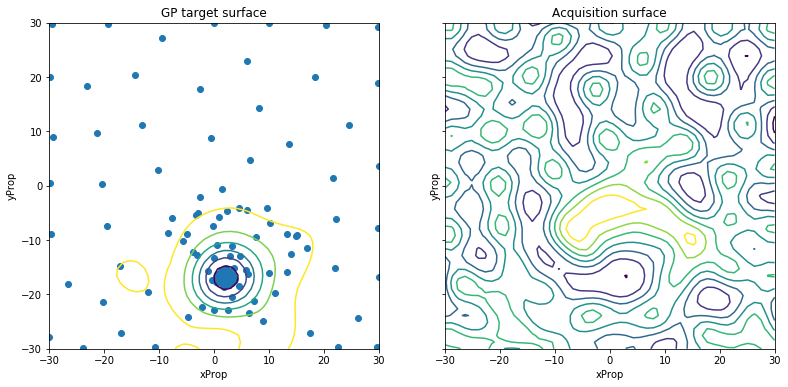

In [21]:
bolfi.plot_state();

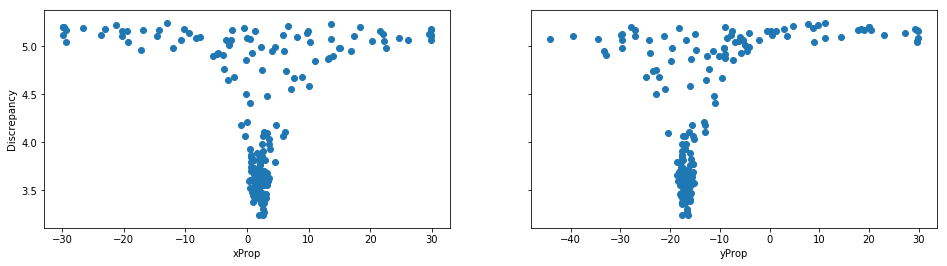

In [22]:
bolfi.plot_discrepancy();

In [23]:
post2 = bolfi.extract_posterior(-1.)

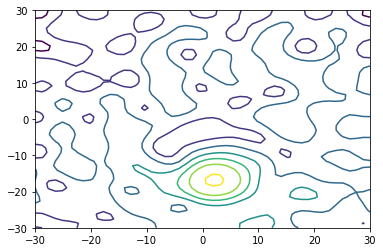

In [24]:
post.plot(logpdf=True)

In [25]:
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
xProp 2396.892746583744 1.0005580365406688
yProp 2643.698140529992 1.0001189800975512
CPU times: user 1min 28s, sys: 1min 14s, total: 2min 43s
Wall time: 40.3 s


In [26]:
result_BOLFI

Method: BOLFI
Number of samples: 2000
Number of simulations: 200
Threshold: 3.58
Sample means: xProp: 2.14, yProp: -16.9

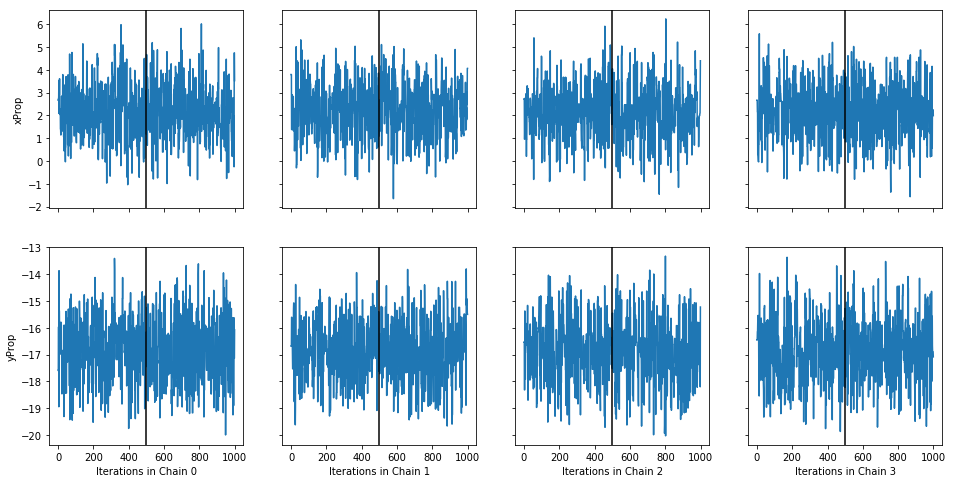

In [27]:
result_BOLFI.plot_traces();

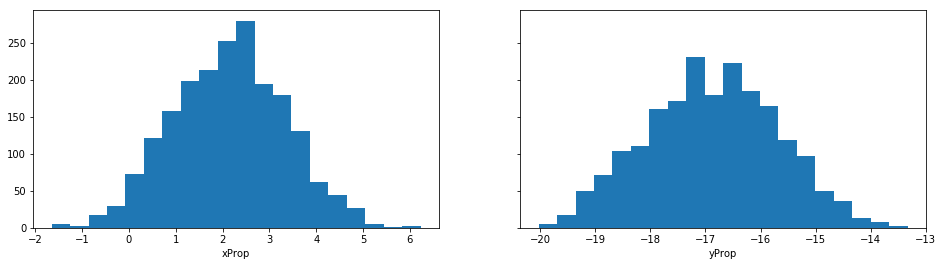

In [28]:
result_BOLFI.plot_marginals();

In [29]:
###Posterior weighted means
result_BOLFI.sample_means

OrderedDict([('xProp', 2.141314298714032), ('yProp', -16.877019222907816)])

In [30]:
print("True Coordinates")
print(trueCoord)
print("Reconstructed Coordinates NN and TPF")
print(pos_dict)
print("Reconstructed Coordinates BOLFI: posterior weighted means")
print(result_BOLFI.sample_means_array)

True Coordinates
[  2.62643434 -17.96082368]
Reconstructed Coordinates NN and TPF
{'PosRecNeuralNet': {'x': 2.349253472591718, 'y': -18.209215419818623}, 'PosRecTopPatternFit': {'x': 2.3690476190476133, 'y': -17.830200501253135}}
Reconstructed Coordinates BOLFI: posterior weighted means
[  2.1413143  -16.87701922]


In [ ]:
#Other objects callable from BOLFI object
#result_BOLFI.plot_pairs();
#result_BOLFI.n_samples
#result_BOLFI.dim
#result_BOLFI.samples_array
#result_BOLFI.summary